- Having too many features pose a problem well known as the curse of dimensionality. 
- The simplest form of selecting features would be to remove features with very low variance. 
- Scikit-learn has an implementation for VarianceThreshold that does precisely this.

In [ ]:
from sklearn.feature_selection import VarianceThreshold
data = ...
var_thresh = VarianceThreshold(threshold=0.1)
transformed_data = var_thresh.fit_transform(data)
# transformed data will have all columns with variance less
# than 0.1 removed

- We can also remove features which have a high correlation.

In [36]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing

# fetch a regression dataset
data = fetch_california_housing()
X = data["data"]
col_names = data["feature_names"]
y = data["target"]

# convert to pandas dataframe
df = pd.DataFrame(X, columns=col_names)

# introduce a highly correlated column
df.loc[:, "MedInc_Sqrt"] = df.MedInc.apply(np.sqrt)

# get correlation matrix (pearson)
df.corr()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedInc_Sqrt
MedInc,1.000000,-0.119034,0.326895,-0.062040,0.004834,0.018766,-0.079809,-0.015176,0.984329
HouseAge,-0.119034,1.000000,-0.153277,-0.077747,-0.296244,0.013191,0.011173,-0.108197,-0.132797
AveRooms,0.326895,-0.153277,1.000000,0.847621,-0.072213,-0.004852,0.106389,-0.027540,0.326688
AveBedrms,-0.062040,-0.077747,0.847621,1.000000,-0.066197,-0.006181,0.069721,0.013344,-0.066910
Population,0.004834,-0.296244,-0.072213,-0.066197,1.000000,0.069863,-0.108785,0.099773,0.018415
AveOccup,0.018766,0.013191,-0.004852,-0.006181,0.069863,1.000000,0.002366,0.002476,0.015266
Latitude,-0.079809,0.011173,0.106389,0.069721,-0.108785,0.002366,1.000000,-0.924664,-0.084303
Longitude,-0.015176,-0.108197,-0.027540,0.013344,0.099773,0.002476,-0.924664,1.000000,-0.015569
MedInc_Sqrt,0.984329,-0.132797,0.326688,-0.066910,0.018415,0.015266,-0.084303,-0.015569,1.000000


We see that the feature MedInc_Sqrt has a very high correlation with MedInc. We
can thus remove one of them. 

### Univariate Feature Selection 

- It is nothing but a scoring of each feature against a given target.
Mutual information, ANOVA F-test and chi2 are some of the most popular
methods for univariate feature selection.

**NOTE:** You can use chi2 only for data which is non-negative in nature.
This is a particularly useful feature selection technique in natural language
processing when we have a bag of words or tf-idf (term frequency - inverse document frequency) based features. 

There are two ways of using these in scikitlearn.
- SelectKBest: It keeps the top-k scoring features
- SelectPercentile: It keeps the top features which are in a percentage
specified by the user

In [37]:
from sklearn.feature_selection import chi2, f_classif, f_regression
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.feature_selection import SelectKBest, SelectPercentile

class UnivariateFeatureSelection:
    def __init__(self, n_features, problem_type, scoring):
        """
        Custom univariate feature selection wrapper for different 
        univariate feature selection models from scikit-learn.

        :param n_features: int for SelectKBest, float for SelectPercentile
        :param problem_type: "classification" or "regression"
        :param scoring: scoring function as a string
        """
        # Define valid scoring methods for the problem type
        if problem_type == "classification":
            valid_scoring = {
                "f_classif": f_classif,
                "chi2": chi2,
                "mutual_info_classif": mutual_info_classif
            }
        else:  # regression
            valid_scoring = {
                "f_regression": f_regression,
                "mutual_info_regression": mutual_info_regression
            }

        # Raise exception if scoring method is invalid
        if scoring not in valid_scoring:
            raise Exception("Invalid scoring function")

        # Initialize the selection method
        if isinstance(n_features, int):
            self.selection = SelectKBest(valid_scoring[scoring], k=n_features)
        elif isinstance(n_features, float):
            self.selection = SelectPercentile(
                valid_scoring[scoring],
                percentile=int(n_features * 100)
            )
        else:
            raise Exception("Invalid type of n_features")

    # Fit function
    def fit(self, X, y):
        return self.selection.fit(X, y)

    # Transform function
    def transform(self, X):
        return self.selection.transform(X)

    # Fit-transform function
    def fit_transform(self, X, y):
        return self.selection.fit_transform(X, y)

In [35]:
import warnings
warnings.filterwarnings("ignore")

ufs = UnivariateFeatureSelection(
    n_features=0.1,
    problem_type="regression",
    scoring="f_regression"
)
ufs.fit(X, y)
X_transformed = ufs.transform(X)

Most of the time, people prefer doing feature selection using a machine
learning model.

### Greedy Feature Selection 

Greedy Feature Selection is one of the simplest model-based feature selection methods. The idea is:

1. Pick a model (like logistic regression, decision tree, linear regression, etc.).
2. Pick a scoring function (like accuracy, F1 score for classification; MSE, R² for regression).
3. Start with zero features.
4. Iteratively test each feature by adding it to the current set of “good” features and fitting the model.
5. If adding this feature improves the score, keep it.
6. If not, discard it.
7. Repeat until all features have been tested.

It’s called “greedy” because it makes decisions one step at a time without looking ahead. At each step, it keeps the feature that improves performance the most, but it might miss better global combinations.

In [32]:
import warnings
warnings.filterwarnings("ignore")


import pandas as pd
from sklearn import linear_model
from sklearn import metrics
from sklearn.datasets import make_classification


class GreedyFeatureSelection:
    """
    A simple and custom class for greedy feature selection.
    You will need to modify it quite a bit to make it suitable
    for your dataset.
    """

    def evaluate_score(self, X, y):
        """
        This function evaluates model on data and returns
        Area Under ROC Curve (AUC).

        NOTE: We fit the data and calculate AUC on same data.
        WE ARE OVERFITTING HERE.
        But this is also a way to achieve greedy selection.

        k-fold will take k times longer.
        If you want to implement it in a really correct way,
        calculate OOF AUC and return mean AUC over k folds.
        This requires only a few lines of change and has been
        shown a few times in this book.
        """

        model = linear_model.LogisticRegression()
        model.fit(X, y)
        predictions = model.predict_proba(X)[:, 1]
        auc = metrics.roc_auc_score(y, predictions)
        return auc

    def _feature_selection(self, X, y):
        """
        This function does the actual greedy selection.
        :param X: data, numpy array
        :param y: targets, numpy array
        :return: (best scores, best features)
        """
        good_features = []
        best_scores = []
        num_features = X.shape[1]

        while True:
            this_feature = None
            best_score = 0

            # try adding each feature
            for feature in range(num_features):
                if feature in good_features:
                    continue

                selected_features = good_features + [feature]
                xtrain = X[:, selected_features]
                score = self.evaluate_score(xtrain, y)

                if score > best_score:
                    this_feature = feature
                    best_score = score

            if this_feature is not None:
                good_features.append(this_feature)
                best_scores.append(best_score)

            # stop if the last feature didn’t improve score
            if len(best_scores) > 2:
                if best_scores[-1] < best_scores[-2]:
                    break

        # return without the last (non-improving) feature
        return best_scores[:-1], good_features[:-1]

    def __call__(self, X, y):
        """
        Call function will call the class on a set of arguments.
        """
        scores, features = self._feature_selection(X, y)
        return X[:, features], scores

if __name__ == "__main__":
    # generate binary classification data
    X, y = make_classification(n_samples=1000, n_features=100)

    # transform data by greedy feature selection
    X_transformed, scores = GreedyFeatureSelection()(X, y)

### Recursive Feature Elimination (RFE)

* **Forward greedy selection:** start with no features and keep **adding the best ones**.
* **RFE (Recursive Feature Elimination):** start with all features and keep **removing the weakest ones**.
* **How to find the weakest feature?**

  * In **linear models** → look at coefficients (close to 0 = weak).
  * In **tree models** → look at feature importance (low = weak).
* **You decide** how many features you want to keep.
* **scikit-learn** already has RFE built-in.

In [43]:
import pandas as pd
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.datasets import fetch_california_housing

# fetch a regression dataset
data = fetch_california_housing()
X = data["data"]
col_names = data["feature_names"]
y = data["target"]
print("Initial number of features ", X.shape[1])

# initialize the model
model = LinearRegression()

# initialize RFE
rfe = RFE(
    estimator=model,
    n_features_to_select=3
)

# fit RFE
rfe.fit(X, y)

# get the transformed data with
# selected columns
X_transformed = rfe.transform(X)
print("Final number of features: ", X_transformed.shape[1])

Initial number of features  8
Final number of features:  3


### Feature Importance

* Another way to select features: **fit a model once** and use its outputs.
* Use **feature coefficients** (for linear models) or **feature importance** (for trees).
* Set a **threshold**:

  * If coefficient/importance > threshold → keep the feature.
  * Else → remove the feature.

In [48]:
import pandas as pd
from sklearn.datasets import load_diabetes
from sklearn.ensemble import RandomForestRegressor

# fetch a regression dataset
# in diabetes data we predict diabetes progression
# after one year based on some features
data = load_diabetes()
X = data["data"]
col_names = data["feature_names"]
y = data["target"]

# initialize the model
model = RandomForestRegressor()

# fit the model
model.fit(X, y)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


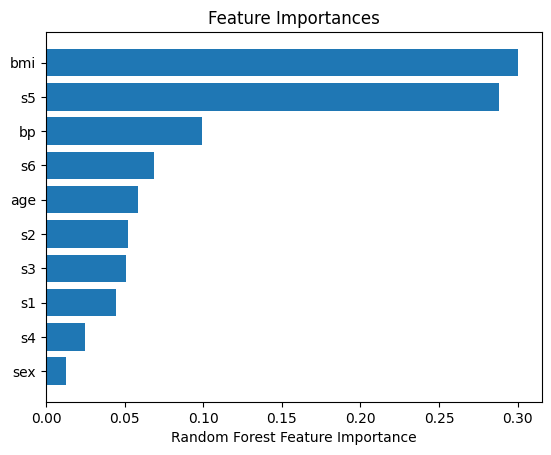

In [49]:
import matplotlib.pyplot as plt 

importances = model.feature_importances_
idxs = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(idxs)), importances[idxs], align='center')
plt.yticks(range(len(idxs)), [col_names[i] for i in idxs])
plt.xlabel('Random Forest Feature Importance')
plt.show()

### Feature Selection Using `SelectFromModel`

* You can select features using one model and train with another (e.g., select with Logistic Regression, train with Random Forest).
* **scikit-learn’s** `SelectFromModel` automates this process.
* Lets you:

  * Choose features directly from model coefficients or feature importances.
  * Set a **threshold** for selection.
  * Limit the **maximum number of features** to keep.

In [50]:
import pandas as pd
from sklearn.datasets import load_diabetes
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

# fetch a regression dataset
# in diabetes data we predict diabetes progression
# after one year based on some features
data = load_diabetes()
X = data["data"]
col_names = data["feature_names"]
y = data["target"]

# initialize the model
model = RandomForestRegressor()

# select from the model
sfm = SelectFromModel(estimator=model)
X_transformed = sfm.fit_transform(X, y)

# see which features were selected
support = sfm.get_support()

# get feature names
print([
    x for x, y in zip(col_names, support) if y == True
])

['bmi', 's5']


* **L1 (Lasso) regularization**:

  * Forces many coefficients to become 0 (or near 0).
  * Keep only features with non-zero coefficients.

* Works with any model that provides feature importance:

  * **Tree-based models** → Random Forest, XGBoost, LightGBM, CatBoost.
  * Different libraries may have different function names or output formats.

* **NOTE:**

  * Always select features using **training data**.
  * Validate the chosen features on **validation data** to avoid overfitting.

In [51]:
# The END